# Build Keras Layers and Model

Test build_layers() and build_model().

In [1]:
import os
import sys
import pathlib
import shutil
from typing import (
    Optional
)

In [2]:
import numpy as np

%matplotlib inline

In [3]:
import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))

from keras.layers import (
    Normalization
)
from keras.models import (
    Model,
)
from tensorflow.keras import backend as K

TensorFlow version: 2.10.0
Eager execution is: True
Keras version: 2.10.0


## PYTHONPATH

In [4]:
path_to_lib: str = str(pathlib.Path(os.path.join(os.getcwd(), "..")).resolve())

In [5]:
type(path_to_lib)

str

In [6]:
sys.path.append(path_to_lib)

In [7]:
%load_ext autoreload
%autoreload 2

from util_matplotlib.image import (
    plot_images,
)
from util_tf.nn import (
    LAYER_NAME_NORM,
    LAYER_NAME_CONV2D,
    LAYER_NAME_MAXPOOL2D,
    LAYER_NAME_DENSE,
    LAYER_NAME_FLAT,
    LAYER_NAME_BN,
    build_layers,
    build_nn_model,
    train,
)

# CIFAR-10
The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

```
class_names = [
    'airplane', 
    'automobile', 
    'bird', 
    'cat', 
    'deer', 
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
]
```

label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example:
```
label_names[0] == "airplane", label_names[1] == "automobile"
```



In [8]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUM_CHANNELS = 3

## Data

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_test_samples = x_test[np.random.choice(a=range(len(x_test)), size=5, replace=False)]

In [10]:
flatten = lambda l: [item for sublist in l for item in sublist]
number_of_classes = len(set(flatten(y_train)))
print("number_of_classes", number_of_classes)

number_of_classes 10


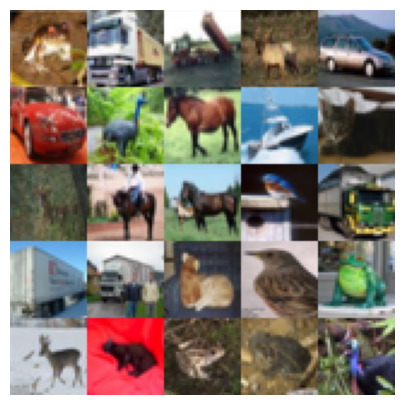

In [11]:
plot_images(x_train[0:25], width=IMAGE_WIDTH, height=IMAGE_HEIGHT, channels=NUM_CHANNELS, figsize=(5,5))

In [12]:
x_train, x_test = tf.cast(x_train, tf.float32), tf.cast(x_test, tf.float32)
y_train, y_test = tf.cast(y_train, tf.uint8), tf.cast(y_test, tf.uint8)

# Use Normalization layer instead of div by 255 gives accuracy improvement approx 20%. Why?
# x_train = x_train / 255.0
# x_test = x_test / 255.0

print(type(x_train))
print(x_train.shape)
print(x_train.dtype)
print(y_train.shape)
print(y_train.dtype)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(50000, 32, 32, 3)
<dtype: 'float32'>
(50000, 1)
<dtype: 'uint8'>


In [13]:
# Reshape data based on channels first / channels last strategy.
# This is dependent on whether you use TF, Theano or CNTK as backend.
# Source: https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py
if K.image_data_format() == 'channels_first':
    input_shape = (1, IMAGE_WIDTH, IMAGE_HEIGHT)
else:
    input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS,)

---
# Data Normalization

In [14]:
normalization = Normalization(
    name="norm",
    input_shape=input_shape,     # (32, 32, 3)
    axis=-1                      # Regard each pixel as a feature
)
normalization.adapt(x_train)

2023-02-16 20:58:35.935435: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


---
# Training
* C: Convolution layer
* P: Pooling layer
* B: Batch normalization layer
* F: Fully connected layer
* O: Output fully connected softmax layer

### Tensorboard callback

In [15]:
# tensorboard --logdir=/full_path_to_your_logs
log_dir = os.path.join(os.getcwd(), "logs")
shutil.rmtree(log_dir, ignore_errors=True)

In [16]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    write_graph=True,
    write_images=True,
    histogram_freq=1,  # How often to log histogram visualizations
    embeddings_freq=1,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

### Early stop callback

In [17]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)

## Model

In [18]:
layers_config = {
    "conv01": {
        "kind": LAYER_NAME_CONV2D, "kernel_size":(3,3), "filters":32, "strides":1, "padding": "same"
    },  
    "maxpool01": {
        "kind": LAYER_NAME_MAXPOOL2D, "pool_size":(2,2), "strides":(2,2), "padding": "valid"
    },
    "conv02": {
        "kind": LAYER_NAME_CONV2D, "kernel_size":(3,3), "filters":32, "strides":1, "padding": "same"
    },
    "conf03": {
        "kind": LAYER_NAME_CONV2D, "kernel_size":(2,2), "filters":32, "strides":1, "padding": "same"
    },
    "conf04": {
        "kind": LAYER_NAME_CONV2D, "kernel_size":(2,2), "filters":32, "strides":1, "padding": "same"
    },
    "maxpool02": {
        "kind": LAYER_NAME_MAXPOOL2D, "pool_size":(2,2), "strides":(2,2), "padding": "valid"
    },
    "flat": {
        "kind": LAYER_NAME_FLAT, "data_format": "channels_last"
    },
    "full01": {
        "kind": LAYER_NAME_DENSE, "units": 100, "activation": "relu", "l2": 1e-2
    },
    "bn01": {
        "kind": LAYER_NAME_BN
    },
    "full02": {
        "kind": LAYER_NAME_DENSE, "units": 50, "activation": "relu", "l2": 1e-2
    },
    "bn02": {
        "kind": LAYER_NAME_BN
    },
    "label": {
        "kind": LAYER_NAME_DENSE, "units": number_of_classes, "activation": "softmax"
    }
}

## Build Model

In [19]:
model: Model = build_nn_model(
    model_name="cifar10",
    input_shape=input_shape,
    layers_config=layers_config,
    normalization=normalization
)

Model: "cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 32, 32, 3)]       0         
                                                                 
 norm (Normalization)        (None, 32, 32, 3)         7         
                                                                 
 conv01 (Conv2DBlock)        (None, 32, 32, 64)        2048      
                                                                 
 maxpool01 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 flat (Flatten)              (None, 16384)             0         
                                                                 
 full (Dense)                (None, 100)               1638500   
                                                                 
 bn (BatchNormalization)     (None, 100)               400 

In [20]:
batch_size = 300
number_of_epochs = 20
validation_split = 0.2
verbosity = 1
use_multiprocessing = True
workers = 4

history = train(
    model=model,
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=number_of_epochs,
    validation_split=validation_split,
    use_multiprocessing=use_multiprocessing,
    workers=workers,
    verbosity=verbosity,
    callbacks=[
        tensorboard_callback,
        earlystop_callback
    ]
)

history.history

Epoch 1/20
134/134 [==============================] - 16s 114ms/step - loss: 2.5418 - accuracy: 0.5002 - val_loss: 2.6624 - val_accuracy: 0.2018
Epoch 2/20
134/134 [==============================] - 17s 125ms/step - loss: 1.5960 - accuracy: 0.5943 - val_loss: 2.3593 - val_accuracy: 0.3430
Epoch 3/20
134/134 [==============================] - 16s 116ms/step - loss: 1.5145 - accuracy: 0.6216 - val_loss: 1.9164 - val_accuracy: 0.4844
Epoch 4/20
134/134 [==============================] - 15s 113ms/step - loss: 1.4667 - accuracy: 0.6342 - val_loss: 1.6102 - val_accuracy: 0.5864
Epoch 5/20
134/134 [==============================] - 15s 112ms/step - loss: 1.4421 - accuracy: 0.6417 - val_loss: 1.5174 - val_accuracy: 0.6128
Epoch 6/20
134/134 [==============================] - 15s 111ms/step - loss: 1.4209 - accuracy: 0.6453 - val_loss: 1.4536 - val_accuracy: 0.6275
Epoch 7/20
134/134 [==============================] - 15s 111ms/step - loss: 1.3967 - accuracy: 0.6546 - val_loss: 1.4729 - val_ac

{'loss': [2.541839122772217,
  1.596036672592163,
  1.5145220756530762,
  1.4666614532470703,
  1.4420521259307861,
  1.420878291130066,
  1.3967125415802002,
  1.3911089897155762,
  1.3812180757522583,
  1.3651973009109497,
  1.3529876470565796,
  1.3404269218444824,
  1.3300986289978027,
  1.3109408617019653,
  1.3109164237976074,
  1.2966948747634888,
  1.2784159183502197,
  1.268062949180603,
  1.2502319812774658,
  1.2443150281906128],
 'accuracy': [0.5002250075340271,
  0.5943250060081482,
  0.6216250061988831,
  0.6342499852180481,
  0.6416500210762024,
  0.6453250050544739,
  0.6546249985694885,
  0.6566749811172485,
  0.6644999980926514,
  0.6679999828338623,
  0.6722249984741211,
  0.6747999787330627,
  0.6814249753952026,
  0.6861000061035156,
  0.6874499917030334,
  0.6925250291824341,
  0.6974999904632568,
  0.7005000114440918,
  0.7081999778747559,
  0.7110499739646912],
 'val_loss': [2.662395715713501,
  2.3592844009399414,
  1.9164479970932007,
  1.610183835029602,
  1.

# History

In [21]:
%load_ext tensorboard
%tensorboard --logdir $log_dir

# Test

In [22]:
results = model.evaluate(x_test, y_test, batch_size=100)
print("test loss, test accuracy:", results)

100/100 [==============================] - 1s 10ms/step - loss: 1.4130 - accuracy: 0.6509
test loss, test accuracy: [1.4129842519760132, 0.6509000062942505]


## Predictions

In [23]:
class_labels = np.array([
    'airplane', 
    'automobile', 
    'bird', 
    'cat', 
    'deer', 
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
])

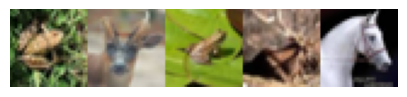

In [24]:
plot_images(x_test_samples, width=IMAGE_WIDTH, height=IMAGE_HEIGHT, channels=NUM_CHANNELS, figsize=(5,5))

In [25]:
predictions = np.argmax(model.predict(x_test_samples), axis=-1)
predictions

1/1 [==============================] - 0s 76ms/step


array([6, 4, 2, 6, 7])

In [26]:
class_labels[predictions]

array(['frog', 'deer', 'bird', 'frog', 'horse'], dtype='<U10')